In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np


/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/genAI-pytorch/bin/../lib/libjpeg.9.dylib

## 1 Load Dataset


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )) # normalize by subtracting mean & dividing by SD, mean = 0.5, SD = 0.5
])

train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform) # transform = convert to pytorch tensor
test_set = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [3]:
type(train_set)

torchvision.datasets.mnist.MNIST

In [4]:
print(f"Number of train data samples: {len(train_set)}")
print(f"Number of test data samples: {len(test_set)}")
print("For each sample, its a tuple of size 2 (label (0 - 9), 1 x 28 x 28 tensor)") # 1 is the channel - i.e grayscale

Number of train data samples: 60000
Number of test data samples: 10000
For each sample, its a tuple of size 2 (label (0 - 9), 1 x 28 x 28 tensor)


In [5]:
batch_size = 64 # larger batchsize = more stable gradients but more computational cost

# don't want to feed 60000 all at once
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## 2 Init Generator & Discriminator Models

### GenBlock and DisBlock

- serves as containers, each serving as specific operations in Generator & Discriminator


In [6]:
# nn.Module
# gain access to several important features that makes building, training and managing DL models easier
# for eg. can define layers as class attributes

class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GenBlock, self).__init__() # init nn.Module
        
        # define layers
        layers = []
        layers.append(nn.Linear(in_channels, out_channels))
        layers.append(nn.ReLU(True))
        
        self.block = nn.Sequential(*layers)

    # passes inputs through the block of layers
    def forward(self, x):
        return self.block(x)

class DisBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DisBlock, self).__init__()
        
        layers = []
        layers.append(nn.Linear(in_channels, out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        layers.append(nn.Dropout(0.2))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

In [7]:
class Generator(nn.Module):
    # Z = random noise vector - normally distributed
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        
        # Generator Layers using GenBLock (more layers = richer details i.e more feature maps)
        self.fc1 = GenBlock(z_dim, 128)
        self.fc2 = GenBlock(128, 256)
        self.fc3 = GenBlock(256, 512)
        self.fc4 = GenBlock(512, 1024)
        self.fc5 = nn.Linear(1024, 28 * 28)
        self.fc6 = nn.Tanh() # transform values to be in range of -1 to 1
        
    def forward(self, z):
        x = self.fc1(z)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        return x.view(-1, 1, 28, 28)  # Reshaping to 28x28

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Discriminator layers using DisBlock
        self.fc1 = DisBlock(28*28, 1024)
        self.fc2 = DisBlock(1024, 512)
        self.fc3 = DisBlock(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.fc5 = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image to a vector
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x  # Output probability

In [8]:
z_dim = 100

# Init models
generator = Generator(z_dim)
discriminator = Discriminator()

criterion = nn.BCELoss()
# for Discriminator = minimize difference between true label and generated image
# for Generator = minimize the discriminator detection of fake image
# adversarial relationship

lr = 0.0002 # step to take during gradient descent
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr) # parameters to be updated for generator
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr) # parameters to be updated for discrimnator

## 3 Train the Models


Epoch [0/100], D Loss: 1.0812941789627075, G Loss: 6.0254716873168945


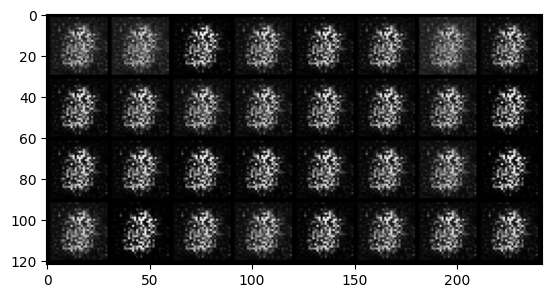

Epoch [10/100], D Loss: 0.27933841943740845, G Loss: 4.468322277069092


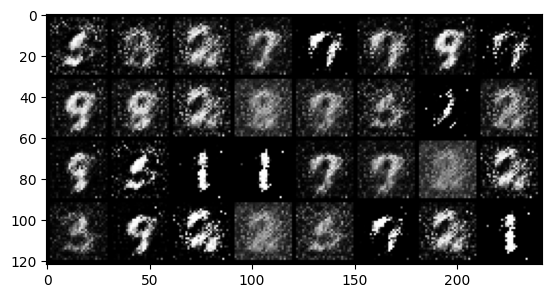

Epoch [20/100], D Loss: 1.0305547714233398, G Loss: 1.7518433332443237


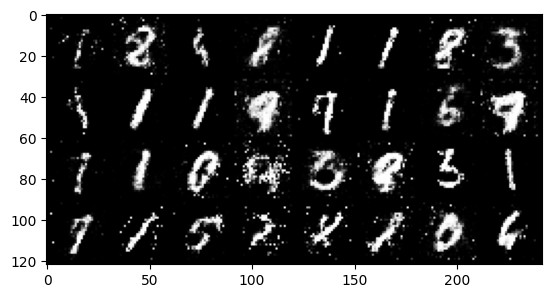

Epoch [30/100], D Loss: 0.8397420644760132, G Loss: 1.57239830493927


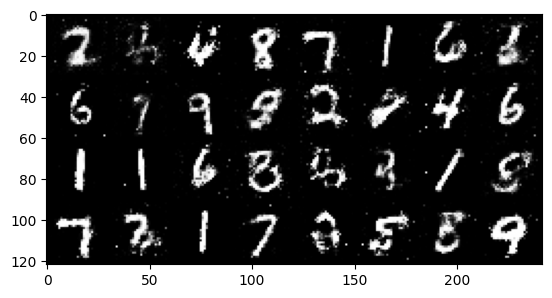

Epoch [40/100], D Loss: 0.9851287603378296, G Loss: 1.1524509191513062


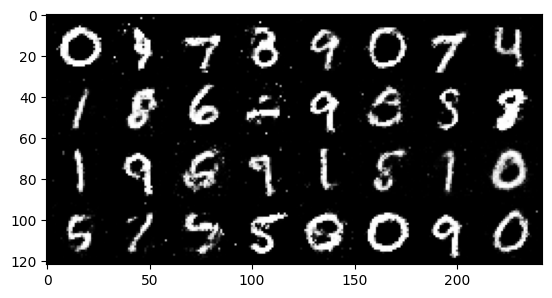

Epoch [50/100], D Loss: 1.042008876800537, G Loss: 1.4181567430496216


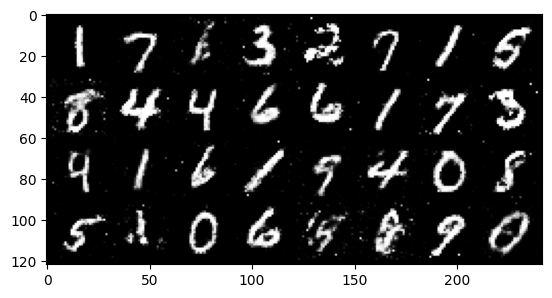

Epoch [60/100], D Loss: 1.2867239713668823, G Loss: 0.7288106679916382


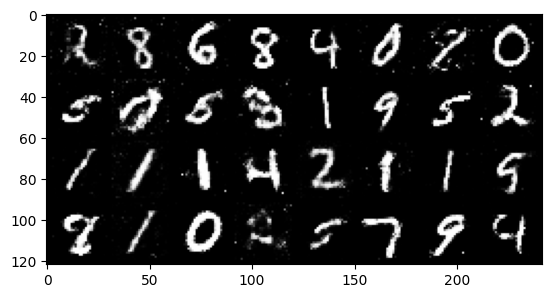

Epoch [70/100], D Loss: 1.1475694179534912, G Loss: 1.0743393898010254


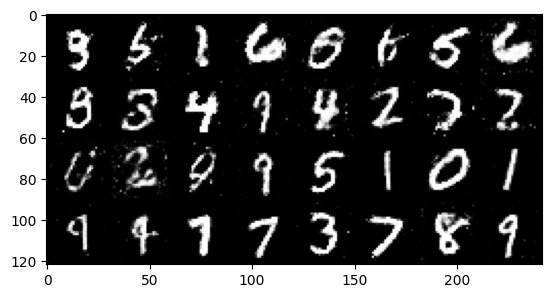

Epoch [80/100], D Loss: 1.1269867420196533, G Loss: 1.2246581315994263


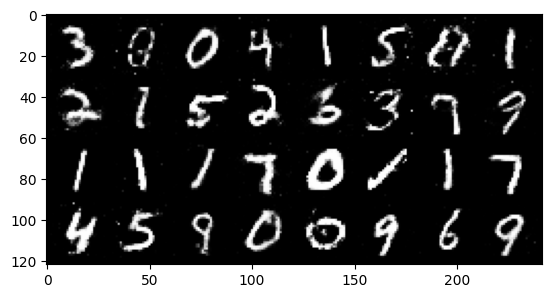

Epoch [90/100], D Loss: 1.161060094833374, G Loss: 0.9862968921661377


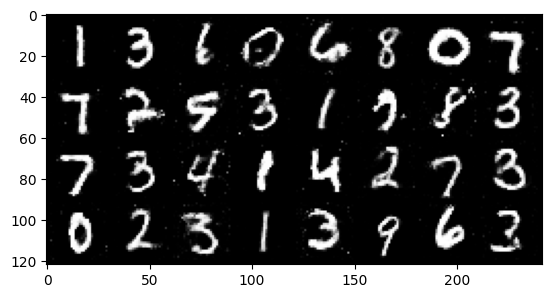

In [9]:
num_epochs = 100

for epoch in range(num_epochs):
    for real_images, _ in train_loader: # labels are not needed in GAN training
        batch_size = real_images.size(0)
        
        # 1 Train Discriminator: minimize - ( log(D(x)) + log(1 - D(G(z))) )

        # generate real & fake labels (for discriminator to make comparison)
        real_labels = torch.ones(batch_size, 1, dtype=torch.float) # probability 1 means image is real
        fake_labels = torch.zeros(batch_size, 1, dtype=torch.float) # probability 0 means image is fake
        
        real_images = real_images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        real_labels = real_labels.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        # pass in real data to discriminator
        real_outputs = discriminator(real_images) # to make output 1D
        d_loss_real = criterion(real_outputs, real_labels) # compare real_output to real_label
        
        # pass in fake data to discriminator
        noise = torch.randn(batch_size, z_dim).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach()) # detach to avoid training generator
        d_loss_fake = criterion(fake_outputs, fake_labels)
    
        # Total Discriminator Loss
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad() # clear gradients before backprop
        d_loss.backward() # backpropagate to calc gradient
        optimizer_D.step() # gradient descent to update weights
        
        
        # 2 Train Generator: minimize -log(D(G(z))) - want to learn from feedback of Discriminator
        fake_outputs = discriminator(fake_images) # pass fake data thru discriminator & generator will see
        g_loss = criterion(fake_outputs, real_labels) # calculate loss between generated data vs real data
        
        optimizer_G.zero_grad() # clear gradients before backprop
        g_loss.backward() # backprop to calc gradient
        optimizer_G.step() # grad desc to update weights
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')
    
        with torch.no_grad(): # temporary disable gradient (saves computation time)
            fake_images = fake_images.reshape(-1, 1, 28, 28)
            grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
            plt.show()
        
        

## 4 Model Prediction & Evaluation

- don't have straightforward loss metric like supervised learning models


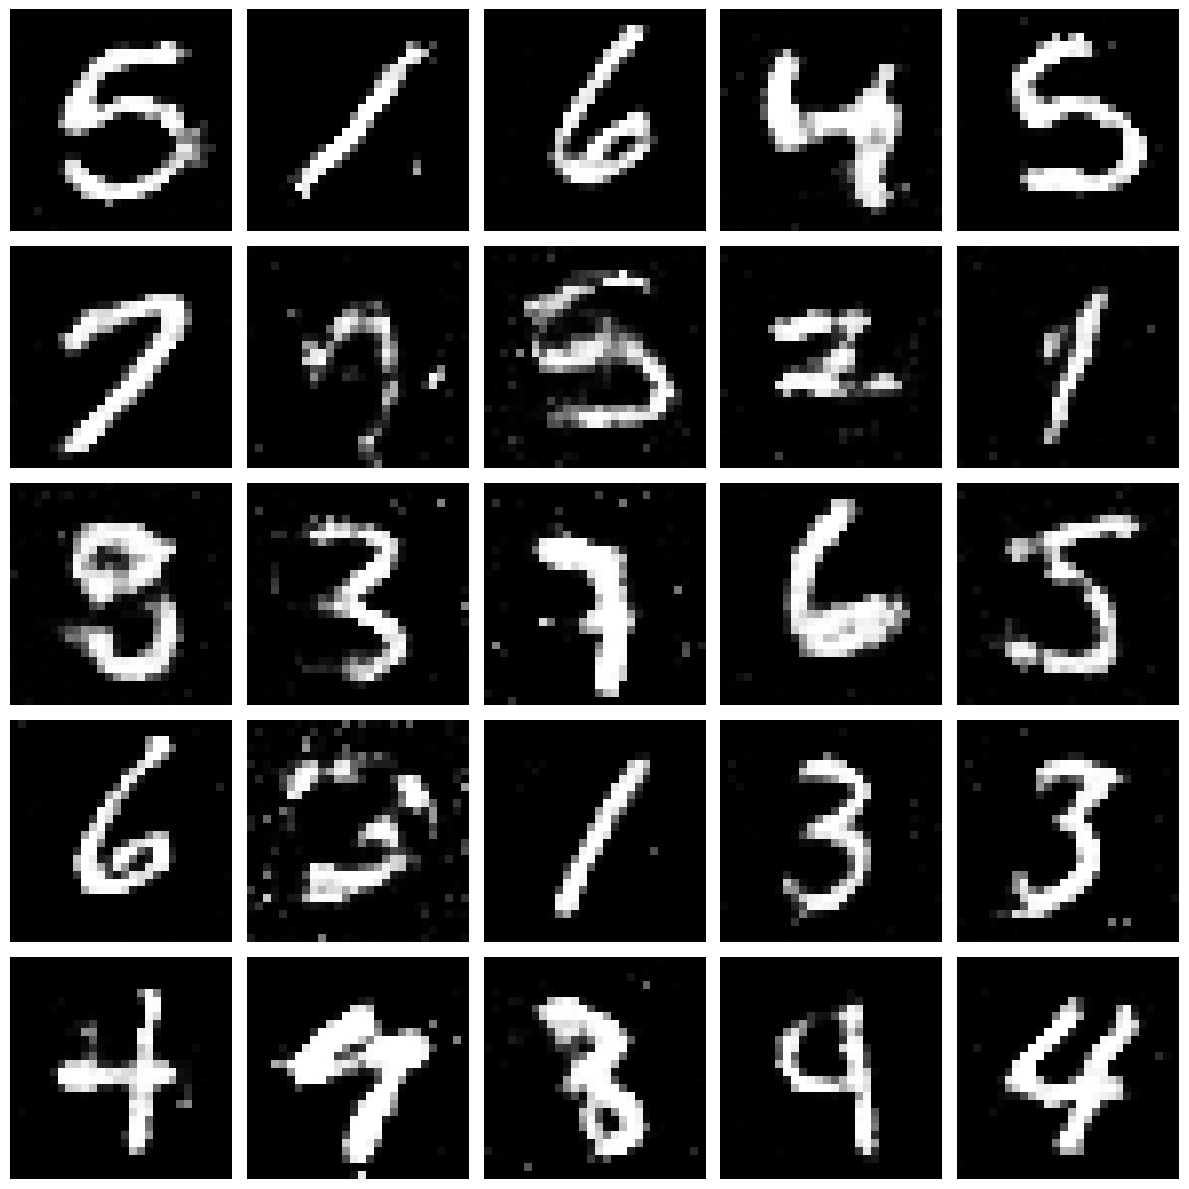

In [19]:
def visualize_generated_images(generator, num_images=25, z_dim=100):
    generator.eval() # set to eval mode
    z = torch.randn(num_images, z_dim)
    with torch.no_grad():
        generated_images = generator(z).cpu()
        
        generated_images = generated_images.view(num_images, 28, 28).numpy()
        fig, axes = plt.subplots(5, 5, figsize=(12, 12))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(generated_images[i], cmap='gray')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

visualize_generated_images(generator)